In [304]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
ts.set_token('457a66c9299e50e9e0b2bf6c2f122bb24d560735f01b443158d1c85e') # 日线接口
pro = ts.pro_api()
# df = pro.daily(ts_code='000001.SH', start_date='20100701', end_date='20190923')
df = ts.pro_bar(ts_code='000300.SH', asset='I', start_date='20100701', end_date='20191201')
look_back=7
foresight=3


/Users/chaozhan/opt/anaconda3/envs/py375/lib/python3.7/site-packages/tushare/util/upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [257]:
df['trade_date'] = pd.to_datetime(df['trade_date'])
df['trade_date'] = df['trade_date'].map(lambda x:x.strftime('%Y-%m-%d'))
# df.set_index('trade_date', inplace=True)
df=df.sort_values(by='trade_date')
df=df.reset_index(drop=True) #重置索引
print(df.shape)
#降序


(2291, 11)


In [258]:
df['RSI'] = talib.RSI(df['close'], timeperiod = 9)
df['WILLR']= talib.WILLR(df['high'], df['low'].values, df['close'].values, 7)
df1=df.dropna()
df1 = df1.drop(['trade_date','ts_code','pre_close','change','pct_chg','vol'],axis=1) #删除
print(df1.shape)

(2282, 7)


In [259]:

train_test_split = int(df1.shape[0]*0.8)
df1=df1.values
print(df1.shape)
# df1_close=df1[:,0]
# df1=np.delete(df1,0,axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)) #不能使用一维的数据
# scaler1_close = MinMaxScaler(feature_range=(0, 1))
df1=scaler.fit_transform(df1)
# df1_close=scaler.fit_transform(df1_close)
# x_train=scaler.fit_transform(x_train)
# x_test=scaler.fit_transform(x_test)
# y_train=scaler.fit_transform(y_train)
# y_test==scaler.fit_transform(y_test)

(2282, 7)


In [260]:
x_pre_train=df1[:train_test_split,:]
x_pre_test=df1[train_test_split:,:]

In [261]:
def create_dataset(dataset, look_back=7, foresight=3):   
    X, Y = [], []
    for i in range(len(dataset)-look_back-foresight): 
        obs = dataset[i:(i+look_back),:] # Sequence of 7 stock prices as features forming an observation                                        
       # Append sequence
        X.append(obs)
       # Append stock price value occurring 4 time-steps into future
        Y.append(dataset[i + (look_back+foresight), 0]) 
    return np.array(X), np.array(Y)

In [262]:
x_train, y_train = create_dataset(x_pre_train)
x_test, y_test = create_dataset(x_pre_test)
print(x_train.shape,y_train.shape)
x_train

(1815, 7, 7) (1815,)


array([[[0.17345561, 0.17003703, 0.1734792 , ..., 0.03048232,
         0.73766734, 0.80629074],
        [0.15965304, 0.17288858, 0.17219947, ..., 0.02180795,
         0.59880627, 0.42449558],
        [0.16198224, 0.1567248 , 0.15407667, ..., 0.01532039,
         0.61180753, 0.44412674],
        ...,
        [0.20036097, 0.18353382, 0.19237186, ..., 0.06437351,
         0.76802052, 0.97254745],
        [0.20214621, 0.2014866 , 0.19849395, ..., 0.05659203,
         0.77339046, 0.90192868],
        [0.212539  , 0.19946545, 0.20368551, ..., 0.04564933,
         0.80384222, 0.99115332]],

       [[0.15965304, 0.17288858, 0.17219947, ..., 0.02180795,
         0.59880627, 0.42449558],
        [0.16198224, 0.1567248 , 0.15407667, ..., 0.01532039,
         0.61180753, 0.44412674],
        [0.1822909 , 0.15523583, 0.17572378, ..., 0.04160916,
         0.70755083, 0.92972126],
        ...,
        [0.20214621, 0.2014866 , 0.19849395, ..., 0.05659203,
         0.77339046, 0.90192868],
        [0.2

In [263]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten
from keras.layers.embeddings import Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('训练历史')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['训练集','验证集'], loc='upper right')
    plt.show()
# print(x_train.shape)
# x_train=x_train.reshape(x_train.shape[0],-1)
# x_test=x_test.reshape(x_test.shape[0],-1)
# print(x_train.shape)

In [264]:
# model = Sequential()
# model.add(Flatten())
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=1,  activation='sigmoid'))
# model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
# train_history = model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=100,  verbose=2)



In [265]:
# min_epoch=train_history.history['loss'].index(min(train_history.history['loss'])) #求最小的epoch在哪个位置
# print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history.history['loss']))
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')
# scores = model.evaluate(x_test, y_test, verbose =1)
# print("测试集数据MSE为",scores[1])

In [266]:
model1 = Sequential()
model1.add(LSTM(128,  input_shape=(look_back, 7), dropout=0.1, recurrent_dropout=0.1))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='mse', optimizer='adam', metrics = ['mse']) 
train_history1 = model1.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=100,  verbose=1)

Train on 1452 samples, validate on 363 samples
Epoch 1/50
1452/1452 [==============================] - 4s 3ms/step - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.0612 - val_mean_squared_error: 0.0612
Epoch 2/50
1452/1452 [==============================] - 0s 188us/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 3/50
1452/1452 [==============================] - 0s 194us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 4/50
1452/1452 [==============================] - 0s 197us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/50
1452/1452 [==============================] - 0s 188us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 9.2061e-04 - val_mean_squared_error: 9.2061e-04
Epoch 6/50
1452/1452 [==============================] - 0s 190us/step - loss: 0.0040 - mean_squared_error: 0.0040 - v

最小的训练轮数是第 32 
最小的训练MSE为 0.0008535528899947843
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128)               69632     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 102,913
Trainable params: 102,913
Non-trainable params: 0
_________________________________________________________________
None
447/447 [==============================] - 0s 77us/step
测试集数据MSE为 0.00507734508005698


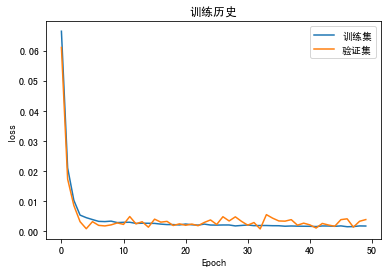

In [267]:
min_epoch=train_history1.history['val_loss'].index(min(train_history1.history['val_loss'])) #求最小的epoch在哪个位置
print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history1.history['val_loss']))
# min_epoch=np.where(np.array(train_history.history['val_loss'])==np.min(train_history.history['val_loss'],axis=0))#另外一种做法
# list(min_epoch)[0][0]
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')

print(model1.summary())
show_train_history(train_history1,'loss','val_loss')

# scores = model.evaluate(x_test, y_test, verbose =2)
# scores
scores = model1.evaluate(x_test, y_test, verbose =1)
print("测试集数据MSE为",scores[1])


447/447 [==============================] - 0s 39us/step
测试集数据MSE [0.0033872869392852787, 0.0033872869392852787]


In [268]:
# test_predict=model.predict(x_test)
# print(test_predict.shape,test_predict)
test_predict=model1.predict(x_test,batch_size=100,verbose=1)
print(test_predict.shape,type(test_predict),test_predict)


447/447 [==============================] - 1s 3ms/step
(447, 1) <class 'numpy.ndarray'> [[0.626528  ]
 [0.64463   ]
 [0.6556709 ]
 [0.64480186]
 [0.64433455]
 [0.5969331 ]
 [0.55197936]
 [0.54845315]
 [0.5410632 ]
 [0.5461666 ]
 [0.5501921 ]
 [0.5246608 ]
 [0.5055826 ]
 [0.48675185]
 [0.46639723]
 [0.45773026]
 [0.46314275]
 [0.46641797]
 [0.4861331 ]
 [0.5075367 ]
 [0.5240436 ]
 [0.51849425]
 [0.49612075]
 [0.4953239 ]
 [0.47474453]
 [0.46988013]
 [0.49020526]
 [0.48690388]
 [0.51061034]
 [0.5278952 ]
 [0.5383946 ]
 [0.5223864 ]
 [0.50701296]
 [0.50673974]
 [0.48717728]
 [0.48808765]
 [0.48980471]
 [0.48810655]
 [0.47722766]
 [0.4673736 ]
 [0.45265347]
 [0.4569553 ]
 [0.44209948]
 [0.4507779 ]
 [0.45582488]
 [0.46861732]
 [0.45913544]
 [0.45402464]
 [0.44838563]
 [0.47263488]
 [0.48065928]
 [0.4667301 ]
 [0.4527276 ]
 [0.43553117]
 [0.42042947]
 [0.42380673]
 [0.43590105]
 [0.43062037]
 [0.42827874]
 [0.45636722]
 [0.4598355 ]
 [0.43823096]
 [0.43015906]
 [0.42856976]
 [0.4365833 ]
 [

In [269]:
# test_predict=test_predict[0:440]
x_pre_test=x_pre_test[look_back+foresight:,1:7]  #x_pre_test=x_pre_test[:-10,1:7] ?????
x_pre_test=np.concatenate([test_predict,x_pre_test], axis=1)
test_predict=scaler.inverse_transform(x_pre_test)
print(x_pre_test.shape)

(447, 7)


In [270]:
print(test_predict.shape,test_predict)

(447, 7) [[ 4.13369873e+03  4.35222110e+03  4.40333750e+03 ...  2.23331309e+08
   8.04865786e+01 -1.40679270e+01]
 [ 4.19283402e+03  4.38705770e+03  4.39590530e+03 ...  2.56176324e+08
   5.62935903e+01 -7.57693642e+01]
 [ 4.22890214e+03  4.28668340e+03  4.30851150e+03 ...  1.86650566e+08
   4.70743508e+01 -9.70141711e+01]
 ...
 [ 3.57990292e+03  3.88342900e+03  3.88997830e+03 ...  1.07238822e+08
   4.34384728e+01 -6.29057417e+01]
 [ 3.54435099e+03  3.87790120e+03  3.88769030e+03 ...  8.70817889e+07
   4.06476306e+01 -7.37526886e+01]
 [ 3.56298098e+03  3.85718830e+03  3.86165840e+03 ...  1.16200557e+08
   3.43725712e+01 -7.90881278e+01]]


In [271]:
test_predict_1line=test_predict[:,0]
test_predict_1line.shape
df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'].values

array([4381.2996, 4302.0181, 4256.1021, 4275.8986, 4245.8978, 4271.2326,
       4274.1464, 4148.8856, 4050.4972, 4012.0472, 3840.6527, 3890.1046,
       3935.6324, 3966.9614, 4052.7332, 4071.0889, 4118.4186, 4058.9806,
       4023.6415, 4049.0863, 4016.461 , 4018.097 , 4066.5647, 4036.6536,
       4077.6001, 4108.8652, 4127.6662, 4091.2533, 4073.3447, 4096.1627,
       4056.4226, 4074.2479, 4077.7041, 4061.0502, 4020.349 , 3904.9355,
       3879.893 , 3913.2689, 3842.7155, 3894.0498, 3898.4977, 3886.9189,
       3862.4796, 3854.8625, 3852.9292, 3927.1729, 3938.3434, 3898.6354,
       3871.1443, 3808.863 , 3748.6412, 3766.282 , 3811.843 , 3760.8543,
       3766.3257, 3843.4886, 3828.7015, 3755.4941, 3756.8765, 3763.6461,
       3793.0001, 3774.5981, 3834.1877, 3878.6767, 3871.6152, 3893.0565,
       3872.8383, 3909.2933, 3924.0975, 3892.8442, 3864.0507, 3903.0637,
       3921.2421, 3906.2081, 3854.5825, 3827.217 , 3816.498 , 3833.2599,
       3804.0093, 3723.3724, 3802.3759, 3770.5891, 

In [272]:
backtest = pd.DataFrame(test_predict_1line,columns=['close_predict'])
backtest['close'] = df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'].values  #同一天
backtest['trade_date'] = df.loc[df.shape[0]-test_predict_1line.shape[0]:,'trade_date'].values
# backtest = pd.DataFrame(test_predict_1line , df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'],columns=['close_predict','close'])

In [273]:
df[df['close']==backtest['close'][0]].trade_date

1844    2018-01-26
Name: trade_date, dtype: object

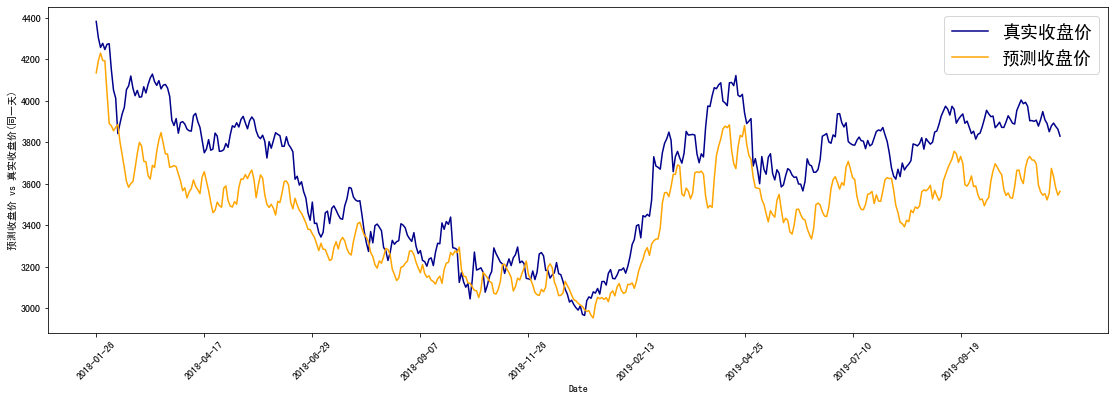

In [274]:
plt.figure(figsize = (19,6))
plt.plot(range(backtest.shape[0]),backtest['close'],color='darkblue',label='真实收盘价')
plt.plot(range(backtest.shape[0]),backtest['close_predict'],color='orange',label='预测收盘价')
plt.xticks(range(0,backtest.shape[0],50),backtest['trade_date'][::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('预测收盘价 vs 真实收盘价(同一天)')
plt.legend(fontsize=18)
plt.show()

In [303]:
backtest['close_3day_before']=backtest['close'].shift(-foresight)
backtest.set_index('trade_date', drop= True, inplace = False)
# print(backtest.loc[0,'trade_date'])
# df1.loc['2017-02-03':'2017-02-06']
backtest.dropna(inplace=True)
print(backtest)




close_predict      close  trade_date  close_3day_before
0      4133.698727  4381.2996  2018-01-26          4275.8986
1      4192.834019  4302.0181  2018-01-29          4245.8978
2      4228.902144  4256.1021  2018-01-30          4271.2326
3      4193.395383  4275.8986  2018-01-31          4274.1464
4      4191.868814  4245.8978  2018-02-01          4148.8856
..             ...        ...         ...                ...
427    3665.245557  3978.1216  2019-11-04          3991.8749
428    3621.115138  4002.8128  2019-11-05          3973.0107
429    3600.293431  3984.8816  2019-11-06          3902.9783
430    3677.176457  3991.8749  2019-11-07          3903.6888
431    3716.827445  3973.0107  2019-11-08          3899.9815

[432 rows x 4 columns]
